In [1]:
%load_ext autoreload
%autoreload 2
import sys
import collections
import numpy as np
# sys.path.append("/private/home/alexandrerame/domainbedv2/")
# sys.path.append("/private/home/alexandrerame/slurmconfig/notebook/data")

sys.path.append("/home/rame/domainbedv2/")

from domainbed.codeplot import plot
plot.plt.style.use('default')
sys.path.append("/data/rame/logs_experiments_notebook/")

In [2]:
plot.plt.rcParams["figure.figsize"] = (6, 6)
# plot.plt.rcParams['text.usetex'] = True
# plot.plt.rcParams['font.family'] = 'serif'
plot.plt.rcParams['font.serif'] = 'Times Roman'
# plot.FORMAT_X = 1
# plot.FORMAT_Y = 3
plot.dict_key_to_label.update(
    {
        "ROUGE_L": "rouge score",
        "Bleu_1": "bleu1 score",
        "Bleu_4": "bleu4 score",
        "METEOR": "meteor score",
        "CIDEr": "cider score"
    }
)
dict_colormaps = plot.create_colormaps()
cmap_redpurpleblue = plot.matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Purples", dict_colormaps),
        plot.get_color_from_cmap("Blues", dict_colormaps)
    ]
)

do_save = True


In [3]:
from captioning import fts_bleu4, fts_bleu, fts_rouge, fts_meteor, fts_bleurouge, fts_bleumeteor, fts_bleubleu4, fts_rougebleu4, fts_cider, fts_ciderbleu, fts_rougecider
from captioning import e2e_bleu, e2e_bleu4, e2e_rouge, e2e_bleurouge, e2e_bleu4rouge, e2e_meteor, e2e_bleubleu4, e2e_bleumeteor, e2e_cider

In [4]:
do_save=True
def get_at_coeff(l_wa, coeff=0.5):
    for l in l_wa:
        if isinstance(l["lambda"], list):
            found_coeff = l["lambda"][0]
        else:
            found_coeff = l["lambda"]
        if found_coeff == coeff:
            return l
    raise ValueError()
arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)

dict_key_to_label = {
    "ROUGE_L": "rouge",
    "Bleu_1": "bleu1",
    "Bleu_4": "bleu4",
    "METEOR": "meteor",
    "CIDEr": "cider"
}

In [8]:
clean_kwargs_scatter = {
    "key_x": "1-lambda",
    "loc": "lower center",
    "colormaps": ["Blues", "Dark_Blues", "Reds", "Oranges", "Greens"],
    "order": "3",
    "title": None,
}
keys_y=["Bleu_1", "Bleu_4", "ROUGE_L", "METEOR", "CIDEr"]

def plot_scatter_captioning(l, key_1, key_2, **kwargs):
    label_1 = dict_key_to_label[key_1]
    label_2 = dict_key_to_label[key_2]
    legendtitle = r"WA: ${label_1}$ $\to$ ${label_2}$".format(label_1=label_1, label_2=label_2)

    plot.plt.rcParams["figure.figsize"] = (6, 4)
    for key in clean_kwargs_scatter.keys():
        if key not in kwargs:
            kwargs[key] = clean_kwargs_scatter[key]
    labels = [dict_key_to_label[key] for key in keys_y]
    markers = ["*" if key in [key_1, key_2] else "o" for key in keys_y]
    linestyles = ["dotted" if key in [key_1, key_2] else "solid" for key in keys_y]
    kwargs["keys_y"] = ["norm|" + key for key in keys_y]
    fig_dr = plot.plot_basic_scatter(
        l,
        labels=labels,
        markers=markers,
        linestyles=linestyles,
        legendtitle=legendtitle,
        **kwargs,
        _dict_key_to_label={"1-lambda": '$\lambda$'}
    )
    plot.plt.rcParams["figure.figsize"] = (6, 6)
    return fig_dr

In [6]:
clean_kwargs = {
    "loc": "lower left",
    "order": "savgol_3_1_quadratic"

}
def plot_captioning(list_l, key_x, key_y, do_annotate=True, loc_lambda=False, **kwargs):
    for key in clean_kwargs.keys():
        if key not in kwargs:
            kwargs[key] = clean_kwargs[key]

    label_x = dict_key_to_label[key_x]
    label_y = dict_key_to_label[key_y]
    label_xy = "{label_x} + {label_y}".format(label_x=label_x, label_y=label_y)
    labels = [
        r"RL: ${label_x}$".format(label_x=label_x
                                        ), r"WA: $init$ $\to$ ${label_x}$".format(label_x=label_x),
        r"RL: ${label_y}$".format(label_y=label_y),
        r"WA: $init$ $\to$ ${label_y}$".format(label_y=label_y),
        r"RL: $\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy),
        r"WA: ${label_x}$ $\to$ ${label_y}$".format(label_x=label_x, label_y=label_y)
    ]
    fig_dr = plot.plot_key(
        list_l,
        key_x=key_x,
        key_y=key_y,
        labels=labels,
        # keycolor="lambda",
        colormaps=['Blues', 'Blues', 'Reds', 'Reds', 'Purples', "Greens"],
        linestyles=['dotted', 'dashed', 'dotted', 'dashed', "dotted", 'solid'],
        **kwargs
    )
    if do_annotate:
        arrowprops.update({"relpos": (0.5, 1)})
        plot.plt.annotate(
            "pre-trained init",
            xy=(list_l[0][0][key_x], list_l[0][0][key_y]),
            ha='left',
            va="top",
            size=plot.SIZE,
            arrowprops=arrowprops
        )
        arrowprops.update({"relpos": (0.5, 0)})
        plot.plt.annotate(
            r"${label_x}$".format(label_x=label_x) + " rewarded",
            xy=(list_l[0][-1][key_x], list_l[0][-1][key_y]),
            ha='right',
            va="bottom",
            size=plot.SIZE,
            arrowprops=arrowprops
        )
        arrowprops.update({"relpos": (0.5, 1)})
        plot.plt.annotate(
            r"${label_y}$".format(label_y=label_y) + " rewarded",
            xy=(list_l[2][-1][key_x], list_l[2][-1][key_y]),
            ha='left',
            va="top",
            size=plot.SIZE,
            arrowprops=arrowprops
        )
        if loc_lambda:
            arrowprops.update({"relpos": (0.5, 0)})
            plot.plt.annotate(
                r"$\lambda=0.5$",
                xy=(get_at_coeff(list_l[5])[key_x], get_at_coeff(list_l[5])[key_y]),
                ha='right',
                va="bottom",
                size=plot.SIZE,
                arrowprops=arrowprops
            )
        else:
            arrowprops.update({"relpos": (0.5, 1)})
            plot.plt.annotate(
                r"$\lambda=0.5$",
                xy=(
                    get_at_coeff(list_l[5])[key_x],
                    get_at_coeff(list_l[5])[key_y]
                ),
                ha='left',
                va="top",
                size=plot.SIZE,
                arrowprops=arrowprops
            )
        del arrowprops["relpos"]
    return fig_dr

# bleu to bleu4

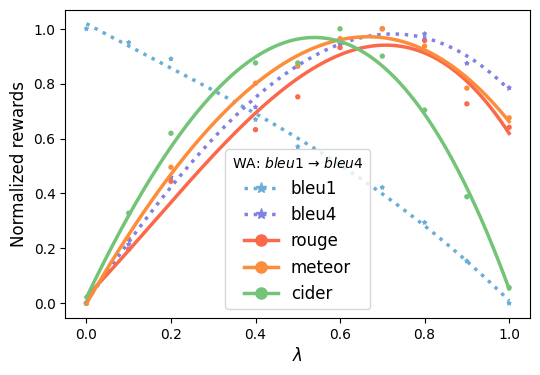

In [9]:
fig_dr = plot_scatter_captioning(l=e2e_bleubleu4.l_wa_bleu4bleu, key_1="Bleu_1", key_2="Bleu_4")
plot.save_fig(fig=fig_dr, name="captioning/lambda_captioning_e2e_bleu1tobleu4.pdf", do_save=do_save)


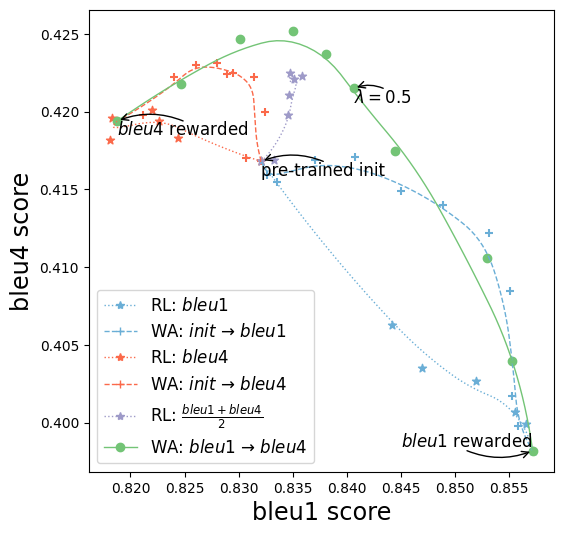

In [10]:
fig_dr = plot_captioning(
    list_l=[
        e2e_bleu.l_step, e2e_bleu.l_wa, e2e_bleu4.l_step, e2e_bleu4.l_wa, e2e_bleubleu4.l_step,
        e2e_bleubleu4.l_wa_bleu4bleu
    ],
    key_x="Bleu_1",
    key_y="Bleu_4"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleu1tobleu4.pdf", do_save=do_save)


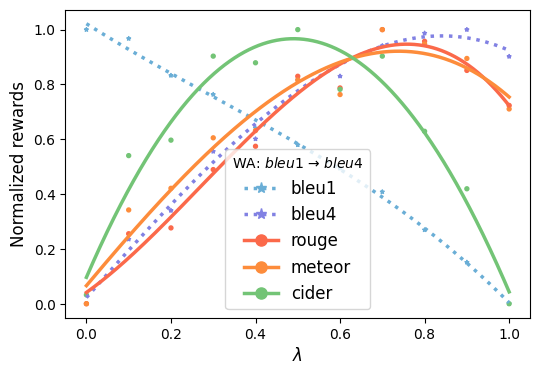

In [11]:
fig_dr = plot_scatter_captioning(l=fts_bleubleu4.l_wa, key_1="Bleu_1", key_2="Bleu_4", order="3")
plot.save_fig(fig=fig_dr, name="captioning/lambda_captioning_bleu1tobleu4.pdf", do_save=do_save,)


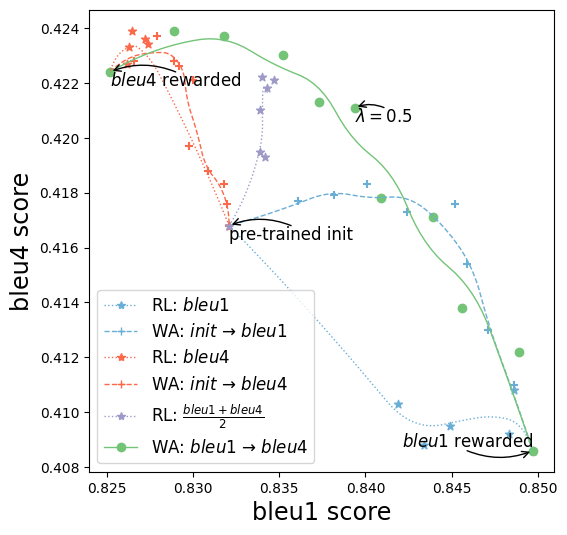

In [12]:
fig_dr = plot_captioning(
    list_l=[
        fts_bleu.l_step, fts_bleu.l_wa, fts_bleu4.l_step, fts_bleu4.l_wa, fts_bleubleu4.l_step,
        fts_bleubleu4.l_wa
    ],
    key_x="Bleu_1",
    key_y="Bleu_4"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1tobleu4.pdf", do_save=do_save)


# bleu to meteor

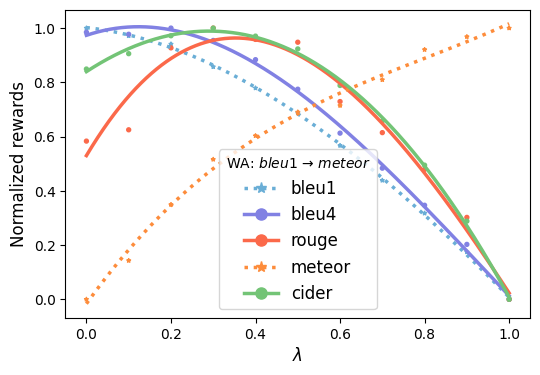

In [13]:
fig_dr = plot_scatter_captioning(
    l=e2e_bleumeteor.l_wa_meteorbleu, key_1="Bleu_1", key_2="METEOR", order="3"
)
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_e2e_bleu1tometeor.pdf",
    do_save=do_save,
)


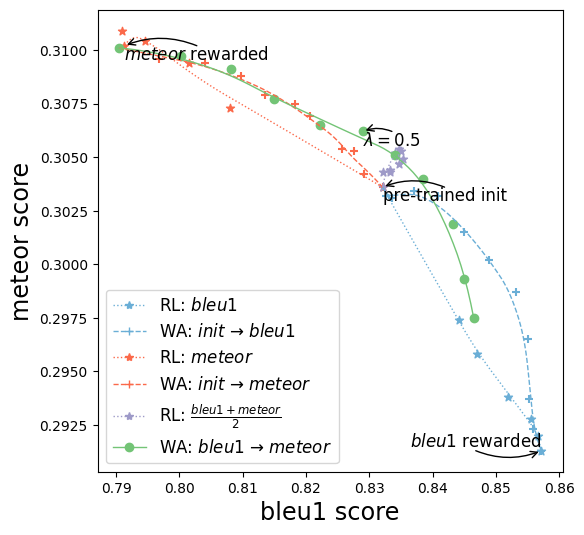

In [14]:
fig_dr = plot_captioning(
    list_l=[
        e2e_bleu.l_step, e2e_bleu.l_wa, e2e_meteor.l_step, e2e_meteor.l_wa, e2e_bleumeteor.l_step,
        e2e_bleumeteor.l_wa_meteorbleu
    ],
    key_x="Bleu_1",
    key_y="METEOR"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleu1tometeor.pdf", do_save=do_save)


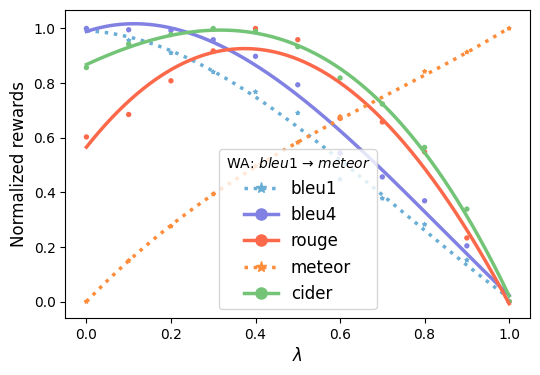

In [15]:
fig_dr = plot_scatter_captioning(l=fts_bleumeteor.l_wa, key_1="Bleu_1", key_2="METEOR", order="3")
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_bleu1tometeor.pdf",
    do_save=do_save,
)


Failed for label: RL: $\frac{bleu1 + meteor}{2}$ because: Expect x to not have duplicates


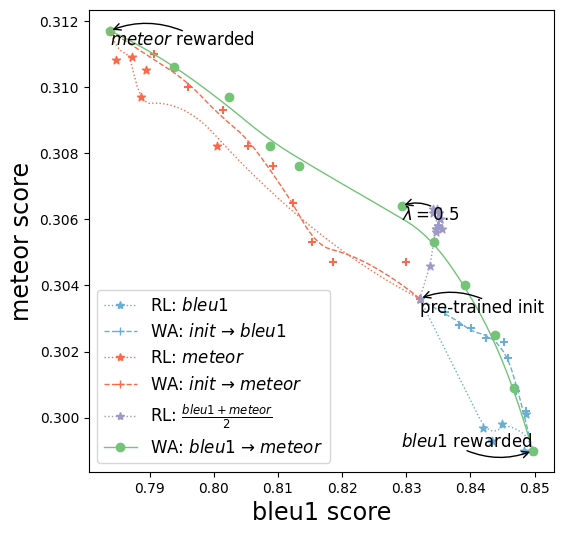

In [16]:
fig_dr = plot_captioning(
    list_l=[
        fts_bleu.l_step,
        fts_bleu.l_wa,
        fts_meteor.l_step,
        fts_meteor.l_wa,
        fts_bleumeteor.l_step,
        fts_bleumeteor.l_wa,
    ],
    key_x="Bleu_1",
    key_y="METEOR"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1tometeor.pdf", do_save=do_save)

# Bleu to ROUGE

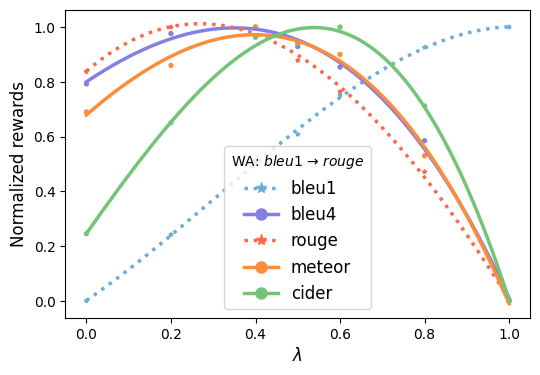

In [17]:
fig_dr = plot_scatter_captioning(
    l=e2e_bleurouge.l_wa_rougebleu, key_1="Bleu_1", key_2="ROUGE_L", order="3", key_x="lambda"
)
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_e2e_bleu1torouge.pdf",
    do_save=do_save,
)


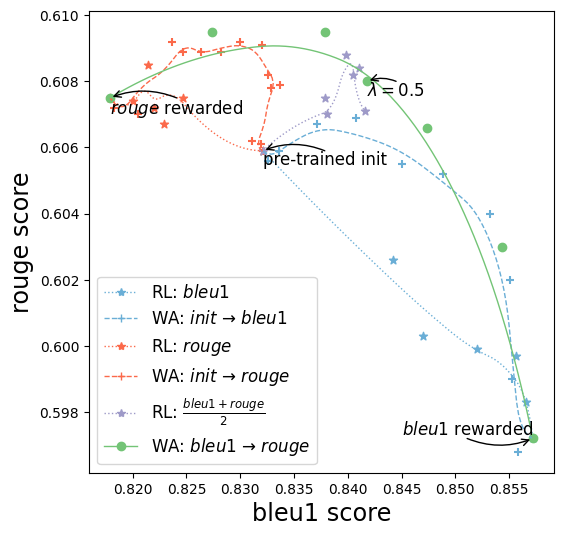

In [18]:
fig_dr = plot_captioning(
    [
        e2e_bleu.l_step, e2e_bleu.l_wa, e2e_rouge.l_step, e2e_rouge.l_wa,
        e2e_bleurouge.l_step_rougebleu, e2e_bleurouge.l_wa_rougebleu
    ],
    key_x="Bleu_1",
    key_y="ROUGE_L"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleu1torouge.pdf", do_save=do_save)


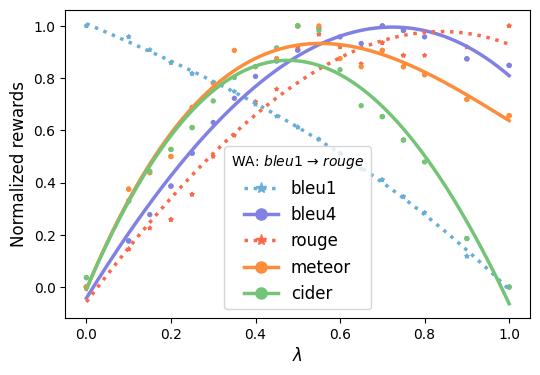

In [19]:
fig_dr = plot_scatter_captioning(
    l=fts_bleurouge.l_wa_epoch5, key_1="Bleu_1", key_2="ROUGE_L", order="3", key_x="lambda"
)
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_bleu1torouge.pdf",
    do_save=do_save,
)


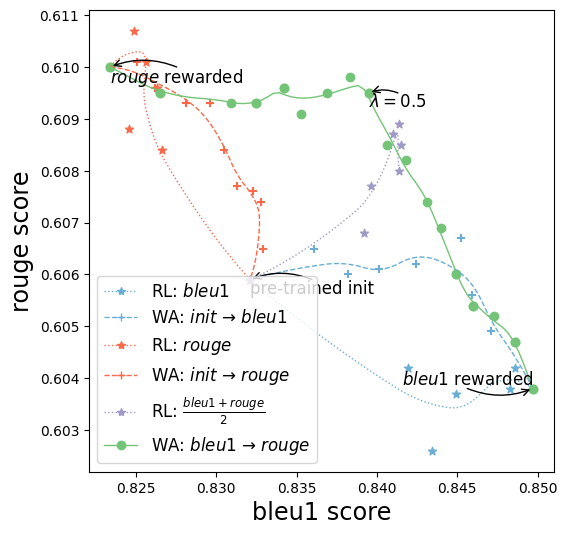

In [20]:
fig_dr = plot_captioning(
    [
        fts_bleu.l_step, fts_bleu.l_wa, fts_rouge.l_step, fts_rouge.l_wa_step5,
        fts_bleurouge.l_step, fts_bleurouge.l_wa_epoch5
    ],
    key_x="Bleu_1",
    key_y="ROUGE_L",
    
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1torouge.pdf", do_save=do_save)

/tmp/rame/ipykernel_3009736/2078882365.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=[plot.cm.get_cmap(cmap_redpurpleblue)((6 - i) / 6) for i in range(7)]


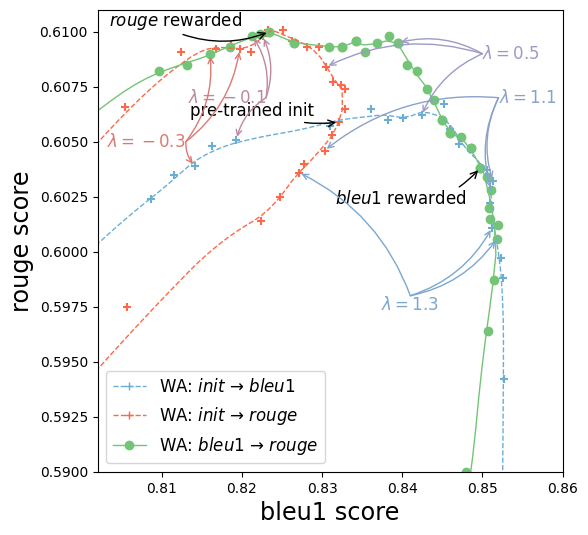

In [21]:
fig_dr = plot_captioning(
    [
        fts_bleu.l_step, fts_bleu.l_extra, fts_rouge.l_step, fts_rouge.l_extra, fts_bleurouge.l_step,
        fts_bleurouge.l_extra
    ],
    key_x="Bleu_1",
    key_y="ROUGE_L",
    loc="lower left",
    order="savgol_3_1_quadratic",
    _dict_key_to_limit={
        "Bleu_1": [0.802, 0.86],
        "ROUGE_L": [0.59, 0.611],
        # "METEOR": [0.29, 0.32]
    },
    list_indexes=[1, 3, 5],
    do_annotate=False
)
key_x="Bleu_1"
key_y="ROUGE_L"
label_x = dict_key_to_label[key_x]
label_y = dict_key_to_label[key_y]

arrowprops.update({"relpos": (0.5, 1)})
plot.plt.annotate(
    "pre-trained init",
    xy=(fts_bleu.l_step[0][key_x], fts_bleu.l_step[0][key_y]),
    xytext=(0.829, 0.606),
    ha='right',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowprops
)

arrowprops.update({"relpos": (0.5, 0)})
plot.plt.annotate(
    r"${label_x}$".format(label_x=label_x) + " rewarded",
    xy=(fts_bleu.l_step[-1][key_x], fts_bleu.l_step[-1][key_y]),
    xytext=(0.848, 0.602),
    ha='right',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowprops
)
arrowprops.update({"relpos": (0.5, 0)})
plot.plt.annotate(
    r"${label_y}$".format(label_y=label_y) + " rewarded",
    xy=(fts_rouge.l_step[-1][key_x], fts_rouge.l_step[-1][key_y]),
    xytext=(0.82, 0.610),
    ha='right',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowprops
)

del arrowprops["relpos"]
colors=[plot.cm.get_cmap(cmap_redpurpleblue)((6 - i) / 6) for i in range(7)]

xytext = (0.85, 0.609)
key = 3
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0, color=colors[key])

plot.plt.annotate(
    r"$\lambda=0.5$",
    xy=xytext,
    xytext=xytext,
    ha='left',
    va="center",
    size=plot.SIZE,
    color=colors[key]
)

plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_extra)[key_x], get_at_coeff(fts_bleurouge.l_extra)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)
plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleu.l_extra)[key_x], get_at_coeff(fts_bleu.l_extra)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)
plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_rouge.l_extra)[key_x], get_at_coeff(fts_rouge.l_extra)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)

xytext = (0.823, 0.607)
key = 4
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0, color=colors[key])
arrowpropskey.update({"relpos": (1, 0.5)})
plot.plt.annotate(
    r"$\lambda=-0.1$",
    xy=xytext,
    xytext=xytext,
    ha='right',
    va="center",
    size=plot.SIZE,
    color=colors[key]
)

plot.plt.annotate(
    "",
    xy=(
        get_at_coeff(fts_bleurouge.l_extra,
                     coeff=1.1)[key_x], get_at_coeff(fts_bleurouge.l_extra, coeff=1.1)[key_y]
    ),
    xytext=xytext,
    arrowprops=arrowpropskey
)
plot.plt.annotate(
    "",
    xy=(
        get_at_coeff(fts_bleu.l_extra, coeff=1.1)[key_x], get_at_coeff(fts_bleu.l_extra,
                                                                       coeff=1.1)[key_y]
    ),
    xytext=xytext,
    arrowprops=arrowpropskey
)
plot.plt.annotate(
    "",
    xy=(
        get_at_coeff(fts_rouge.l_extra,
                     coeff=-0.1)[key_x], get_at_coeff(fts_rouge.l_extra, coeff=-0.1)[key_y]
    ),
    xytext=xytext,
    arrowprops=arrowpropskey
)

xytext = (0.813, 0.605)
key = 5
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0, color=colors[key])
arrowpropskey.update({"relpos": (1, 0.5)})
plot.plt.annotate(
    r"$\lambda=-0.3$",
    xy=xytext,
    xytext=xytext,
    ha='right',
    va="center",
    size=plot.SIZE,
    color=colors[key]
)

plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_extra, coeff=1.3)[key_x], get_at_coeff(fts_bleurouge.l_extra, coeff=1.3)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)
plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleu.l_extra, coeff=1.3)[key_x], get_at_coeff(fts_bleu.l_extra, coeff=1.3)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)
plot.plt.annotate(
    "",
    xy=(
        get_at_coeff(fts_rouge.l_extra,
                     coeff=-0.3)[key_x], get_at_coeff(fts_rouge.l_extra, coeff=-0.3)[key_y]
    ),
    xytext=xytext,
    arrowprops=arrowpropskey
)

xytext = (0.852, 0.607)
key = 2
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0, color=colors[key])
arrowpropskey.update({"relpos": (0.5, 1)})
plot.plt.annotate(
    r"$\lambda=1.1$",
    xy=xytext,
    xytext=xytext,
    ha='left',
    va="center",
    size=plot.SIZE,
    color=colors[key]
)

plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_extra, coeff=-0.1)[key_x], get_at_coeff(fts_bleurouge.l_extra, coeff=-0.1)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)
plot.plt.annotate(
    "",
    xy=(
        get_at_coeff(fts_bleu.l_extra,
                     coeff=-0.1)[key_x], get_at_coeff(fts_bleu.l_extra, coeff=-0.1)[key_y]
    ),
    xytext=xytext,
    arrowprops=arrowpropskey
)
plot.plt.annotate(
    "",
    xy=(
        get_at_coeff(fts_rouge.l_extra,
                     coeff=1.1)[key_x], get_at_coeff(fts_rouge.l_extra, coeff=1.1)[key_y]
    ),
    xytext=xytext,
    arrowprops=arrowpropskey
)

xytext = (0.841, 0.598)
key = 1
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0, color=colors[key])
arrowpropskey.update({"relpos": (1, 1)})
plot.plt.annotate(
    r"$\lambda=1.3$",
    xy=xytext,
    xytext=xytext,
    ha='center',
    va="top",
    size=plot.SIZE,
    color=colors[key]
)

plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_extra, coeff=-0.3)[key_x], get_at_coeff(fts_bleurouge.l_extra, coeff=-0.3)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)
plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleu.l_extra, coeff=-0.3)[key_x], get_at_coeff(fts_bleu.l_extra, coeff=-0.3)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)
plot.plt.annotate(
    "",
    xy=(
        get_at_coeff(fts_rouge.l_extra,
                     coeff=1.3)[key_x], get_at_coeff(fts_rouge.l_extra, coeff=1.3)[key_y]
    ),
    xytext=xytext,
    arrowprops=arrowpropskey
)

plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1torouge_extra.pdf", do_save=do_save)

# bleu4 to rouge

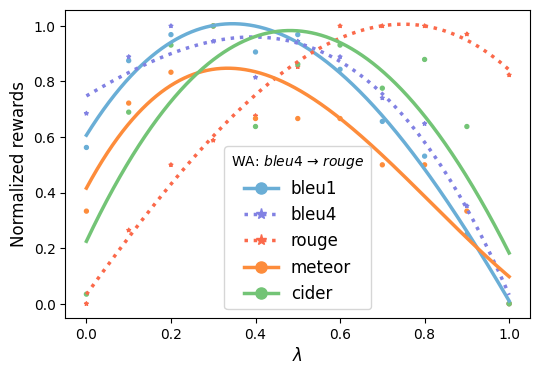

In [22]:
fig_dr = plot_scatter_captioning(
    l=fts_rougebleu4.l_wa, key_1="Bleu_4", key_2="ROUGE_L", order="3", key_x="lambda"
)
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_bleu4torouge.pdf",
    do_save=do_save,
)


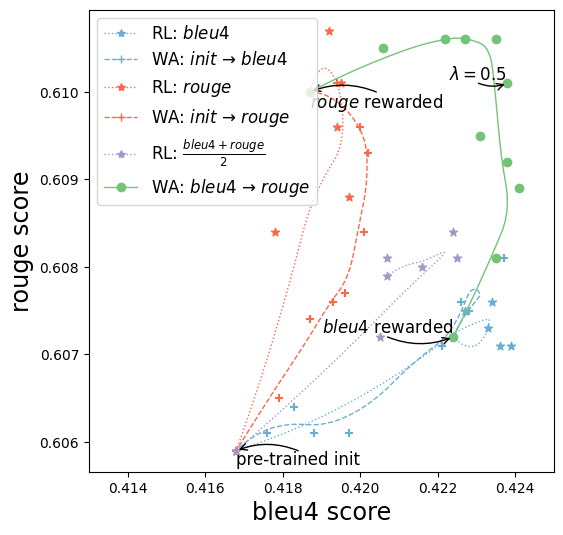

In [23]:
fig_dr = plot_captioning(
    [
        fts_bleu4.l_step,
        fts_bleu4.l_wa,
        fts_rouge.l_step,
        fts_rouge.l_wa_step5,
        fts_rougebleu4.l_step,
        fts_rougebleu4.l_wa,
    ],
    key_x="Bleu_4",
    key_y="ROUGE_L",
    loc="upper left",
    loc_lambda="left",    
    _dict_key_to_limit={"Bleu_4": [0.413,0.425]}
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu4torouge.pdf", do_save=do_save)

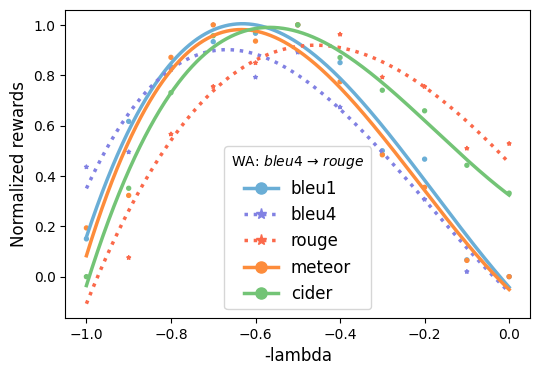

In [24]:
fig_dr = plot_scatter_captioning(
    l=e2e_bleu4rouge.l_wa, key_1="Bleu_4", key_2="ROUGE_L", order="3", key_x="-lambda"
)
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_e2e_bleu4torouge.pdf",
    do_save=do_save,
)


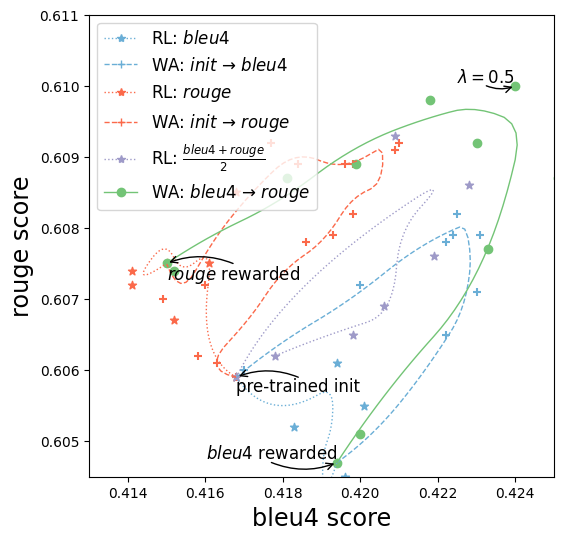

In [25]:
fig_dr = plot_captioning(
    [
        e2e_bleu4.l_step, e2e_bleu4.l_wa, e2e_rouge.l_step, e2e_rouge.l_wa, e2e_bleu4rouge.l_step,
        e2e_bleu4rouge.l_wa
    ],
    key_x="Bleu_4",
    key_y="ROUGE_L",
    loc="upper left",
    loc_lambda="left",
    _dict_key_to_limit={"Bleu_4": [0.413, 0.425], "ROUGE_L": [0.6045, 0.611]}
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleu4torouge.pdf", do_save=do_save)

# CIDER

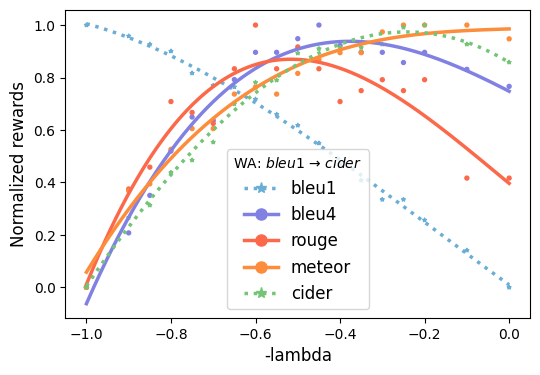

In [26]:
fig_dr = plot_scatter_captioning(
    l=fts_ciderbleu.l_wa, key_1="Bleu_1", key_2="CIDEr", order="3", key_x="-lambda"
)
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_bleu1tocider.pdf",
    do_save=do_save,
)


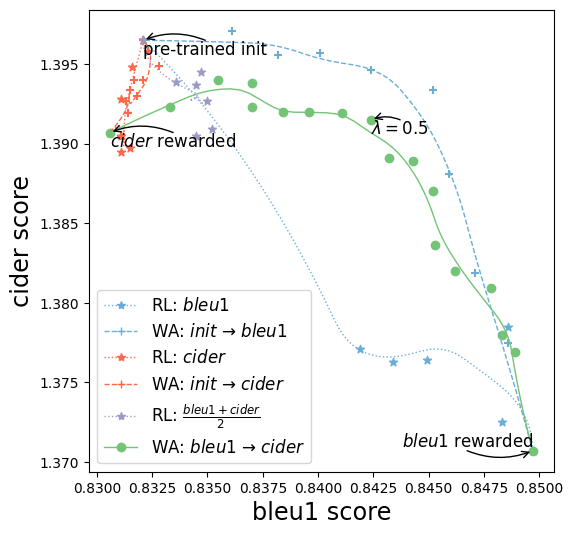

In [27]:
# [
#     fts_bleu.l_step,
#     fts_bleu.l_wa,
#     fts_cider.l_step,
#     fts_cider.l_wa,
#     e2e_cider.l_step,
#     fts_ciderbleu.l_step,
#     fts_ciderbleu.l_wa,
#     fts_rougecider.l_wa
# ],

fig_dr = plot_captioning(
    [
        fts_bleu.l_step, fts_bleu.l_wa, fts_cider.l_step, fts_cider.l_wa, 
        fts_ciderbleu.l_step, fts_ciderbleu.l_wa,
    ],
    key_x="Bleu_1",
    key_y="CIDEr",
    loc="lower left"
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1tocider.pdf", do_save=do_save)

# Bleu rouge enriched

In [ ]:
# plot.plt.rcParams["figure.figsize"] = (6, 6)
# plot.SIZE = "large"
# plot.SIZE_AXIS = "xx-large"

In [ ]:

key_x = "Bleu_1"
key_y = "ROUGE_L"

dict_key_to_label = {
    "ROUGE_L": "rouge",
    "Bleu_1": "bleu1",
    "Bleu_4": "bleu4",
    "METEOR": "meteor",
    "CIDEr": "cider"
}

label_x = dict_key_to_label[key_x]
label_y = dict_key_to_label[key_y]


def plot_captioning_enriched(list_l, order="savgol_3_1_quadratic", **kwargs):
    fig_dr = plot.plot_key(
        list_l,
        key_x=key_x,
        key_y=key_y,
        order=order,
        **kwargs,
    )
    arrowprops.update({"relpos": (0.5, 1)})    
    plot.plt.annotate(
        "pre-trained init",
        xy=(fts_bleu.l_step[0][key_x], fts_bleu.l_step[0][key_y]),
        ha='left',
        va="top",
        size=plot.SIZE,
        arrowprops=arrowprops
    )
    arrowprops.update({"relpos": (0.5, 0)})    
    plot.plt.annotate(
        r"${label_x}$".format(label_x=label_x) + " rewarded",
        xy=(fts_bleu.l_step[-1][key_x], fts_bleu.l_step[-1][key_y]),
        ha='right',
        va="bottom",
        size=plot.SIZE,
        arrowprops=arrowprops
    )
    arrowprops.update({"relpos": (0.5, 1)})    
    plot.plt.annotate(
        r"${label_y}$".format(label_y=label_y) + " rewarded",
        xy=(fts_rouge.l_step[-1][key_x], fts_rouge.l_step[-1][key_y]),
        ha='left',
        va="top",
        size=plot.SIZE,
        arrowprops=arrowprops
    )    
    return fig_dr

In [ ]:
colors = [plot.cm.get_cmap(cmap_redpurpleblue)((8 - i) / 8) for i in range(9)] + [plot.get_color_from_cmap("Greens", dict_colormaps)]
colors[3] = plot.cm.get_cmap("Purples")(0.5)

fig_dr = plot_captioning_enriched(
    [
        fts_bleu.l_step,
        fts_bleurouge.l_step_bleu4rouge1,
        fts_bleurouge.l_step_15,
        fts_bleurouge.l_step_bleu3rouge2,
        fts_bleurouge.l_step,
        fts_bleurouge.l_step_bleu2rouge3,
        fts_bleurouge.l_step_51,
        fts_bleurouge.l_step_bleu1rouge4,
        fts_rouge.l_step,
        fts_bleurouge.l_wa_epoch5,
    ],
    labels=[
        r"RL: $\mu=0$ (only $bleu1$)", r"RL: $\mu=0.2$", r"RL: $\mu=0.33$", r"RL: $\mu=0.4$",
        r"RL: $\mu=0.50$", r"RL: $\mu=0.6$", r"RL: $\mu=0.66$", r"RL: $\mu=0.8$",
        r"RL: $\mu=1$ (only $rouge$)", r"WA: $bleu1$ $\to$ $rouge$"
    ],
    linestyles=[
        "dotted",
        "dashdot",
        "dashed",
        "dotted",
        "dashdot",
        "dashed",
        "dotted",
        "dashdot",
        "dashed",
        "solid",
    ],
    colormaps=None,
    keycolor=None,
    # colors=[
    #     plot.get_color_from_cmap("Blues", dict_colormaps),
    #     plot.get_color_from_cmap("Blues_Greens", dict_colormaps),
    #     plot.get_color_from_cmap("Blues_Greens", dict_colormaps),
    #     plot.get_color_from_cmap("Greens", dict_colormaps),
    #     plot.get_color_from_cmap("Reds_Greens", dict_colormaps),
    #     plot.get_color_from_cmap("Reds", dict_colormaps),
    #     plot.get_color_from_cmap("Purples", dict_colormaps),
    # ],
    # order="connect",
    colors=colors,
    _dict_key_to_limit={
        # "Bleu_1": [0.82, 0.851],
        # "ROUGE_L": [0.601, 0.611],
        # "METEOR": [0.29, 0.32]
    },
    loc="lower left",
    fontsize="medium"
)

plot.save_fig(
    fig=fig_dr, name="captioning/pareto_captioning_bleu1torouge_multimu.pdf", do_save=do_save
)


In [ ]:
fig_dr = plot_captioning_enriched(
    [
        fts_bleu.l_step,
        fts_rouge.l_step,
        fts_bleurouge.l_step,
        fts_bleurouge.l_wa_epoch5,
        fts_bleurouge.l_wa_bleu_multi,
        fts_bleurouge.l_wa_rouge_multi,
    ],
    labels=[
        r"RL: $bleu1$",
        r"RL: $rouge$",
        r"RL: $\frac{bleu1 + rouge}{2}$",
        r"WA: $bleu1 \to rouge$",
        r"WA: $bleu1 \to \frac{bleu1 + rouge}{2}$",
        r"WA: $rouge \to \frac{bleu1 + rouge}{2}$",
    ],
    colormaps=None,
    colors=[
        plot.cm.get_cmap("Blues")(0.5),
        plot.cm.get_cmap("Reds")(0.5),
        plot.cm.get_cmap("Purples")(0.5),
        plot.cm.get_cmap("Greens")(0.5),
        plot.cm.get_cmap(cmap_redpurpleblue)(4 / 5),
        plot.cm.get_cmap(cmap_redpurpleblue)(2 / 5)
    ],
    linestyles=[
        "dotted",
        "dotted",
        "dotted",
        "solid",
        "dashdot",
        "dashdot",
    ],
    _dict_key_to_limit={
        # "Bleu_1": [0.82, 0.852],
        # "ROUGE_L": [0.609, 0.611],
        # "METEOR": [0.29, 0.32]
    },
    loc="lower left"
)


label_xy = "{label_x} + {label_y}".format(label_x=label_x, label_y=label_y)
plot.plt.annotate(
    r"$\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy) + "\nrewarded",
    xy=(fts_bleurouge.l_step[-1][key_x], fts_bleurouge.l_step[-1][key_y]),
    ha='left',
    va="center",
    xytext=(0.8448,0.609),
    size=plot.SIZE,
    arrowprops=arrowprops
)


plot.save_fig(
    fig=fig_dr, name="captioning/pareto_captioning_bleu1torouge_multi.pdf", do_save=do_save
)


In [ ]:
fig_dr = plot_captioning_enriched(
    [
        fts_bleu.l_step, fts_rouge.l_step, fts_bleurouge.l_step, fts_bleurouge.l_wa_epoch5,
        fts_bleurouge.l_ens,
        #fts_bleurouge.l_ens_step10
    ],
    labels=[
        r"RL: $bleu1$",
        r"RL: $rouge$",
        r"RL: $\frac{bleu1 + rouge}{2}$",
        r"WA: $bleu1 \to rouge$",
        r"ENS: $bleu1 \to rouge$",
        r"ENS: $bleu1 \to rouge$ step10",
    ],
    colormaps=["Blues", "Reds", "Purples", "Greens", "Greys"],
    linestyles=[
        "dotted",
        "dotted",
        "dotted",
        "solid",
        "dashdot",
        "dashdot",
    ],
    _dict_key_to_limit={
        # "Bleu_1": [0.82, 0.852],
        # "ROUGE_L": [0.609, 0.611],
        # "METEOR": [0.29, 0.32]
    },
    loc="lower left"
)


plot.save_fig(
    fig=fig_dr, name="captioning/pareto_captioning_bleu1torouge_ens.pdf", do_save=do_save
)

In [ ]:
fig_dr = plot.plot_key(
    [
        fts_bleu.l_step,
        fts_bleu.l_stepv2,
        fts_bleu.l_wa,
        fts_bleu.l_soup,
        fts_rouge.l_step,
        fts_rouge.l_stepv2,
        fts_rouge.l_wa_step5,
        fts_rouge.l_soup,
        fts_bleurouge.l_step,
        fts_bleurouge.l_wa_epoch5,
        fts_bleurouge.l_wa_v22,
        fts_bleurouge.l_wa_v12,
        fts_bleurouge.l_wa_v21,
    ],
    fontsize="medium",
    list_indexes=[0, 1, 3, 4, 5, 7, -4, -3, -2, -1],
    labels=[
        r"RL: $bleu1$ v1",
        r"RL: $bleu1$ v2",
        r"WA S: $init \to {label_x}$".format(label_x=label_x),
        r"WA: ${label_x}$ v1 $\to$ ${label_x}$ v2".format(label_x=label_x),
        r"RL: $rouge$ v1",
        r"RL: $rouge$ v2",
        r"WA: $init \to {label_y}$".format(label_y=label_y),
        r"WA: ${label_y}$ v1 $\to$ ${label_y}$ v2".format(label_y=label_y),
        r"RL: $\frac{bleu1 + rouge}{2}$",
        r"WA: $bleu1$ v1 $\to$ $rouge$ v1",
        r"WA: $bleu1$ v2 $\to$ $rouge$ v2",
        r"WA: $bleu1$ v1 $\to$ $rouge$ v2",
        r"WA: $bleu1$ v2 $\to$ $rouge$ v1",
    ],
    colormaps=None,
    keycolor=None,
    colors=[
        plot.get_color_from_cmap("Blues", dict_colormaps),
        plot.get_color_from_cmap("Blues", dict_colormaps),
        plot.get_color_from_cmap("Blues", dict_colormaps),
        plot.get_color_from_cmap("Blues_Greens", dict_colormaps),
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Reds_Greens", dict_colormaps),
        plot.get_color_from_cmap("Purples", dict_colormaps),
        plot.get_color_from_cmap("Greens", dict_colormaps),
        plot.get_color_from_cmap("Greens", dict_colormaps),
        plot.get_color_from_cmap("Greens", dict_colormaps),
        plot.get_color_from_cmap("Greens", dict_colormaps),
    ],
    linestyles=[
        "dotted", "dashdot", "dashdot", "solid", "dotted", "dashdot", "dashdot", "solid", "dotted",
        "solid", "solid", "solid", "solid"
    ],
    markers=["o", "+", "+", "x", "o", "+", "+", "x", "o", "1", "2", "3", "4"],
    _dict_key_to_limit={
        # "Bleu_1": [0.78, 0.86],
        # "ROUGE_L": [0.609, 0.611],
        # "METEOR": [0.29, 0.32]
    },
    loc="lower left",
    key_x=key_x,
    key_y=key_y,
    order="savgol_3_1_slinear"
)
arrowprops.update({"relpos": (0.5, 1)})
plot.plt.annotate(
    "pre-trained init",
    xy=(fts_bleu.l_step[0][key_x], fts_bleu.l_step[0][key_y]),
    ha='left',
    va="center",
    size=plot.SIZE,
    arrowprops=arrowprops
)

xytext=(0.846, 0.6032)

arrowprops.update({"relpos": (0.5, 0)})
plot.plt.annotate(
    r"${label_x}$".format(label_x=label_x) + "\nrewarded",
    xy=xytext,
    xytext=xytext,
    ha='right',
    va="center",
    size=plot.SIZE,
)

arrowprops.update({"relpos": (0.5, 1)})
plot.plt.annotate(
    r"$\lambda=0.5$" + "\nbetween\n" + r"two $bleu1$",
    xy=(get_at_coeff(fts_bleu.l_soup)[key_x], get_at_coeff(fts_bleu.l_soup)[key_y]),
    xytext=(0.8465, 0.6065),
    size=plot.SIZE,
    ha='left',
    va="center",
    arrowprops=arrowprops
)

plot.plt.annotate(
    "",
    xy=(fts_bleu.l_step[-1][key_x], fts_bleu.l_step[-1][key_y]),
    xytext=xytext,
    size=plot.SIZE,
    arrowprops=arrowprops
)

plot.plt.annotate(
    "",
    xy=(fts_bleu.l_stepv2[-1][key_x], fts_bleu.l_stepv2[-1][key_y]),
    xytext=xytext,
    size=plot.SIZE,
    arrowprops=arrowprops
)



xytext=(0.829, 0.6083)


plot.plt.annotate(
    r"${label_y}$".format(label_y=label_y) + "\nrewarded",
    xy=xytext,
    xytext=xytext,
    ha='left',
    va="center",
    size=plot.SIZE,
)

arrowprops.update({"relpos": (0., 0.5)})
plot.plt.annotate(
    r"$\lambda=0.5$" + "\nbetween\n" + r"two $rouge$",
    xy=(get_at_coeff(fts_rouge.l_soup)[key_x], get_at_coeff(fts_rouge.l_soup)[key_y]),
    xytext=(0.829, 0.6102),
    size=plot.SIZE,
    ha='left',
    va="center",
    arrowprops=arrowprops
)

plot.plt.annotate(
    "",
    xy=(fts_rouge.l_step[-1][key_x], fts_rouge.l_step[-1][key_y]),
    xytext=xytext,
    size=plot.SIZE,
    ha='left',
    va="center",
    arrowprops=arrowprops
)

plot.plt.annotate(
    "",
    xy=(fts_rouge.l_stepv2[-1][key_x], fts_rouge.l_stepv2[-1][key_y]),
    xytext=xytext,
    size=plot.SIZE,
    ha='left',
    va="center",
    arrowprops=arrowprops
)



xytext = (0.8428, 0.609)

plot.plt.annotate(
    r"$\lambda=0.5$" + " between\n" + r"$bleu1$ and $rouge$",
    xy=xytext,
    xytext=xytext,
    ha='left',
    va="center",
    size=plot.SIZE,
)

plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5)[key_y]),
    xytext=xytext,
    size=plot.SIZE,
    arrowprops=arrowprops
)
plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_wa_v22)[key_x], get_at_coeff(fts_bleurouge.l_wa_v22)[key_y]),
    xytext=xytext,
    size=plot.SIZE,
    arrowprops=arrowprops
)
plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_wa_v12)[key_x], get_at_coeff(fts_bleurouge.l_wa_v12)[key_y]),
    xytext=xytext,
    size=plot.SIZE,
    arrowprops=arrowprops
)
plot.plt.annotate(
    "",
    xy=(
        get_at_coeff(fts_bleurouge.l_wa_v21)[key_x], get_at_coeff(fts_bleurouge.l_wa_v21
                                                                    )[key_y]
    ),
    xytext=xytext,
    size=plot.SIZE,
    arrowprops=arrowprops
)

plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1torouge_soup.pdf", do_save=do_save)

In [ ]:
# fig_dr = plot_captioning_enriched(
#     [
#         fts_bleu.l_step_epoch10, fts_bleu.l_stepv2, fts_bleu.l_wa, fts_bleu.l_wa_epochx,
#         fts_bleu.l_wa_step5to10, fts_bleu.l_soup, fts_rouge.l_step_epoch10, fts_rouge.l_stepv2,
#         fts_rouge.l_wa_step5, fts_rouge.l_wa_step5to10, fts_rouge.l_soup, fts_bleurouge.l_step,
#         fts_bleurouge.l_step_15, fts_bleurouge.l_step_51, fts_bleurouge.l_wa_epoch5,
#         fts_bleurouge.l_wa_epoch10, fts_bleurouge.l_wa_bleu_multi, fts_bleurouge.l_wa_rouge_multi,
#         fts_bleurouge.l_ens, fts_bleurouge.l_ens_step10
#     ],
#     # list_indexes = [5],
#     key_x="Bleu_1",
#     key_y="ROUGE_L",
#     labels=[
#         r"RL $bleu$ reward",
#         r"RL $bleu$ reward v2",
#         r"WA $init \to bleu$ epoch 5",
#         r"WA $init \to bleu$ epoch x",
#         r"WA $bleu5 \to bleu10$",
#         r"WA $bleu5 \to bleu5$ soups",
#         r"RL $rouge$ reward",
#         r"RL $rouge$ reward v2",
#         r"WA $init \to rouge$",
#         r"WA $rouge5 \to rouge10$",
#         r"WA $rouge5 \to rouge5$ soups",
#         r"RL $bleu+rouge$ reward",
#         r"RL $bleu+0.5 \times rouge$ reward",
#         r"RL $0.5 \times bleu+ rouge$ reward",
#         r"WA $rouge \to bleu$ epoch 5",
#         r"WA $rouge \to bleu$ epoch 10",
#         r"WA $bleu \to multi$ epoch 5",
#         r"WA $rouge \to multi$ epoch 5",
#         r"ENS $rouge \to bleu$ epoch 5",
#     ],
#     colormaps=[
#         "Blues", "Blues", "Blues", "Blues", "Blues", "Dark_Blues", "Reds", "Reds", "Reds", "Reds",
#         "Oranges", "Purples", "Greens", "Greens", "Greens", "Greens", "Greens", "Greys", "Greys",
#         "Yellows", "Yellows"
#     ],
#     linestyles=[
#         "solid", "solid", "dashed", "dashed", "dotted", "dotted", "solid", "solid", "dashed",
#         "dashed", "dashed", "solid", "solid", "solid", "dotted", "dashdot", "dashdot", "dashed",
#         "dashed", "solid", "dashed"
#     ],
#     _dict_key_to_limit={
#         # "Bleu_1": [0.78, 0.86],
#         # "ROUGE_L": [0.609, 0.611],
#         # "METEOR": [0.29, 0.32]
#     },
#     loc="lower left"
# )
# plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleutorouge_enriched.pdf", do_save=do_save)